Plain example of NSGT for modifying audio


In [1]:
input_fname = "drop.wav"
spectrogram_fname = "spectrogram.tiff"
modified_spectrogram_fname = "modified_spectrogram.tiff"
reconstructed_fname = "reconstructed.wav"
modified_fname = "modified.wav"


In [ ]:
import torch
from nsgt import OctScale
from nsgt.nsgfwin_sl import nsgfwin
import matplotlib.pyplot as plt

scale = OctScale

nbins= 10
scl : OctScale = scale(20,20000,10)

f, q = scl()

g, rfbas, M = nsgfwin(f,q,1000,12000, sliced=False, dtype=torch.float64)


def plot_nsgfwin_results(g, rfbas, M):
    fig, ax = plt.subplots(figsize=(12,6))
    
    # Plot each window function
    for i, window in enumerate(g):
        # Center each window at its frequency position
        center = rfbas[i]
        x = torch.arange(len(window)) + center - len(window)//2
        ax.plot(x, M[i]- window * M[i], alpha=0.5, label=f'Window {i}')
    
    ax.set_xlabel('Sample index')
    ax.set_ylabel('Amplitude') 
    ax.set_title('NSGT Window Functions')
    ax.grid(True)
    
    # Only show legend if there aren't too many windows
    if len(g) <= 10:
        ax.legend()
        
    plt.tight_layout()
    return fig

In [ ]:
import os
from warnings import warn
import torch
import numpy
from nsgt.plot import spectrogram

from nsgt import NSGT, NSGT_sliced, LogScale, LinScale, MelScale, OctScale, VQLogScale, BarkScale, SndReader
from nsgt.fscale import Pow2Scale


import matplotlib.pyplot as plt



PATH = "C:\Projects\workspace\guitar.wav"
if not os.path.exists(PATH):
    print("Input file '%s' not found"%PATH)
    exit(1)

fs = 48000
# build transform
scale = OctScale

fmin, fmax = 30, 24000
nbins = 48
scl = scale(fmin, fmax, nbins)


freqs, qs = scl()


# Read audio data
sf = SndReader(PATH, sr=fs, chns=1)
mono = sf()

signal = [torch.tensor(sig) for sig in mono]
signal = torch.cat(signal, dim=-1)
# mix down signal to mono
mono = torch.mean(signal, dim=0)
signal = torch.unsqueeze(mono, dim=0)



# A Nonsliced NSGT
cqt = NSGT(scl, fs, signal.shape[-1],
                real=True,
                matrixform=True, 
                multichannel=True,
                device="cpu",
            )



# total number of coefficients to represent input signal
#ncoefs = int(sf.frames*cqt.coef_factor)

# generator for forward transformation
c = cqt.forward(signal)
print(c.shape)

# Convert tensor to list of frequency bins
# When reconstructing, use the list format
re_signal = cqt.backward(c)

# add a batch
# c = torch.unsqueeze(c, dim=0)

print(c.shape)

transform_name = 'NSGT'

mag = torch.abs(c)

(mag < 0.0).any()

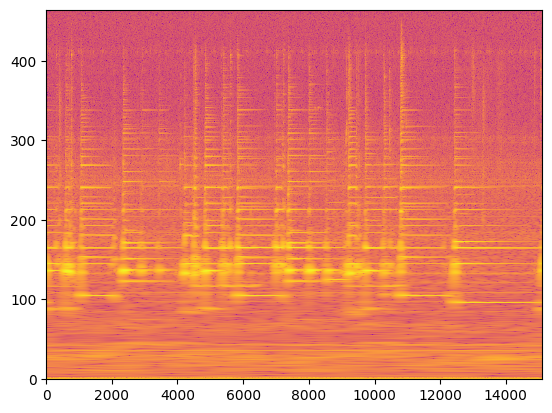

In [63]:
def plot_simple(c, transform_name):
    # plot the magnitude spectrogram
    # drop the channel dimension
    c = c.squeeze(0)

    plt.figure()
    plt.imshow(
        numpy.abs(c),
        aspect='auto',
        origin='lower',
        interpolation='nearest',
        norm='log',
        cmap='plasma'
    )
    plt.show()

plot_simple(c, transform_name)


# RGB - Complex Encoding Schema

| Channel | Encoding |
|---------|----------|
| R       | Magnitude |
| G       | Log normalised magnitude (display value) |
| B       | Phase |



In [64]:
from tifffile import imwrite, imread

def debug_plots(mag, logmag, phase):
    # debug plots
    plt.figure().suptitle("Magnitude")
    plt.imshow(
        mag,
        aspect='auto',
        origin='lower',
    )
    plt.figure().suptitle("Log Normalized Magnitude")
    plt.imshow(
        logmag,
        aspect='auto',
        origin='lower',
    )
    plt.figure().suptitle("Phase")
    plt.imshow(
        phase,
        aspect='auto',
        origin='lower',
    )
    plt.show()

def rgb_complex_spectrum(c):
    # R -> magnitude
    # G -> log normalized magnitude (0 to 1)
    # B -> phase
    # plot the magnitude spectrogram

    # get the magnitude
    mag = torch.abs(c)

    # normalize the magnitude to log 

    logmag = numpy.log1p(mag)
    logmag /= mag.max()

    print (mag.max())

    # get the phase
    phase = torch.angle(c)

    debug_plots(mag, logmag, phase)

    return torch.stack([mag, logmag, phase], dim=-1)

    
import numpy as np
def export_mono(c):
    def orient_image(img):
        # flip top to bottom
        img = np.flipud(img)
        return img

    # export the coefficients to a file
    # drop the channel dimension
    c = c.squeeze(0)

    # get the rgb encoded spectrum
    spectrum = rgb_complex_spectrum(c)

    # convert to numpy
    spectrum = spectrum.numpy()

    # convert to image
    spectrum = orient_image(spectrum)

    
    imwrite(spectrogram_fname, spectrum, photometric='rgb', dtype='float32')

    # save the image
    
def decode_rgb_complex(mono_spectrum : numpy.ndarray) -> torch.Tensor: 
    # convert to tensor
    mono_spectrum = torch.tensor(mono_spectrum)

    # get the magnitude
    mag = mono_spectrum[:,:,0]
    mag = torch.clamp(mag, 0.0, 1.0)

    # get the log normalized magnitude
    logmag = mono_spectrum[:,:,1]

    # get the phase angle
    phase = mono_spectrum[:,:,2]

    # # denormalize the log magnitude
    # mag = numpy.expm1(logmag)

    # convert to complex
    c = mag * torch.exp(1j * phase)

    return c


def import_mono(img_name) -> torch.Tensor:
    def orient_image(img):
        # orient the image
        img = np.flipud(img)
        # avoid striding error by copying
        return img.copy() 
    
    spectrum = imread(img_name)
    spectrum = orient_image(spectrum)

    # decode the rgb spectrum
    c = decode_rgb_complex(spectrum)

    # reintroduce the channel dimension
    c = torch.unsqueeze(c, dim=0)
    # repeat the data across channels
    c = c.repeat(2, 1, 1)

    return c



# Reconstruct from file (no modifications)

tensor(5.0314)


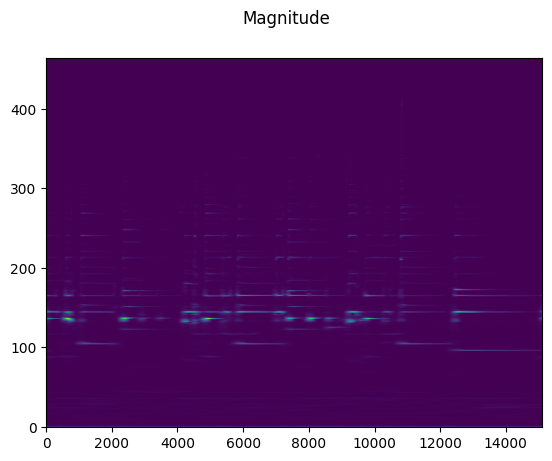

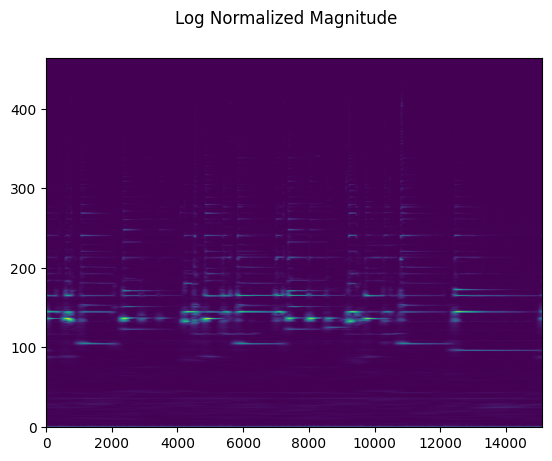

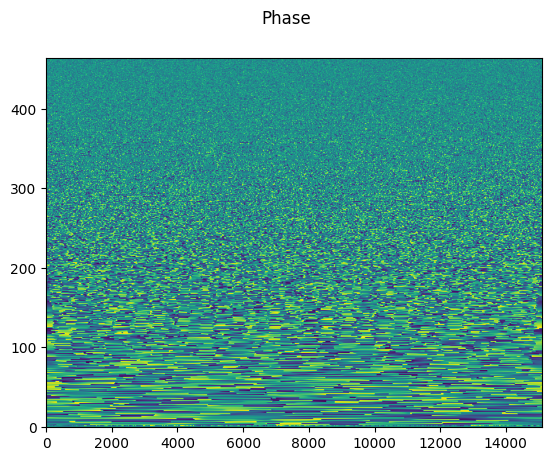

torch.Size([2, 1053696])


In [65]:

export_mono(c)


from nsgt.audio import SndWriter
c = import_mono(spectrogram_fname)

# Reconstruct the signal
signal = cqt.backward(c)


print(signal.shape)
writer = SndWriter(reconstructed_fname, fs)
writer(signal)


# Editing spectrograms

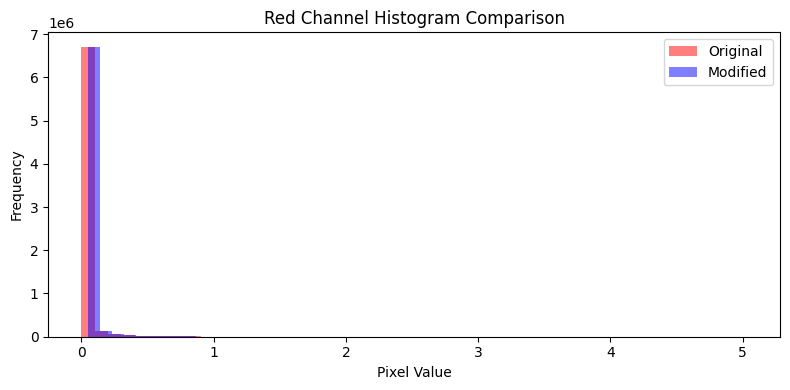

In [66]:
from wand.image import Image as WImage
from wand.image import CHANNELS
from tifffile import imread

with WImage(filename=spectrogram_fname) as img:
    
    ## identity modification
    img.brightness_contrast(+0.0, -10.0, CHANNELS['red'])
    ## shift image up by 48 pixels over black background

    
    img.save(filename=modified_spectrogram_fname)
    


# Plot histograms of red channel values
import matplotlib.pyplot as plt
import numpy as np

# Read original image
original = imread(spectrogram_fname)
modified = imread(modified_spectrogram_fname)

# Create single plot
fig, ax = plt.subplots(figsize=(8,4))

# Plot histograms overlaid
ax.hist(original[:,:,0].flatten(), bins=50, color='red', alpha=0.5, label='Original')
ax.hist(modified[:,:,0].flatten(), bins=50, color='blue', alpha=0.5, label='Modified')

ax.set_title('Red Channel Histogram Comparison')
ax.set_xlabel('Pixel Value')
ax.set_ylabel('Frequency')
ax.legend()

plt.tight_layout()
plt.show()


The image histogram reveals negative coefficient values, these should be clipped before processing as large negative coefficients lead to phase incoherence.

# Loading and reconstructing the signal


In [67]:
# Trying different edits
with WImage(filename=spectrogram_fname) as img:
    
    ## identity modification
    # img.brightness_contrast(+0.0, +100.0, CHANNELS['red'])
    ## shift image up by 48 pixels over black background
    
    img.save(filename=modified_spectrogram_fname)

In [76]:
# Load modified spectrogram


modified_spectrogram = imread(modified_spectrogram_fname)


c = import_mono(modified_spectrogram_fname)


signal = cqt.backward(c)

writer = SndWriter(modified_fname, fs)
writer(signal)

